In [1]:
cd ../..

/home/users/cdonoso/astromer/ASTROMER


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys,os
import multiprocessing as mp
import itertools
from joblib import Parallel, delayed

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

%load_ext autoreload
%autoreload 2

In [90]:
light_curves_path = './data/raw_data/macho/LCs/'
metadata_path = './data/raw_data/macho/train_meta.csv'

In [91]:
meta = pd.read_csv(metadata_path)
change_labels = {'LPV WoodA':'LPV', 'LPV WoodB':'LPV', 'LPV WoodC':'LPV', 'LPV WoodD':'LPV'}
meta['Class'] = meta['Class'].replace(change_labels)
meta = meta[meta['Class']!='UNK']
meta = meta[meta['Class']!='std']
meta = meta[meta['Class']!='Dubious']
meta = meta.rename(columns={'Path_R':'Path'})
# meta['Path'] = meta['objID'].apply(lambda x: str(x)+'.dat') # only for ATLAS
meta['Class'].value_counts()

NonVar    1454792
Name: Class, dtype: int64

In [92]:
def get_delta(row, lc_path, **kwargs):
    lc = pd.read_csv(os.path.join(lc_path, row['Path'].split('/')[-1]), **kwargs)
    delta = lc.iloc[:, 1].diff().dropna()
    return delta

def get_col(row, lc_path, **kwargs):
    lc = pd.read_csv(os.path.join(lc_path, row['Path'].split('/')[-1]), **kwargs)
    return lc.iloc[:, 1]

In [93]:
%%time
# delim_whitespace=True, names=['mjd', 'mag', 'err']
var = Parallel(n_jobs=16)(delayed(get_col)(row, light_curves_path) \
                            for index, row in meta.iterrows())

CPU times: user 7min 21s, sys: 11.4 s, total: 7min 33s
Wall time: 7min 29s


In [94]:
var = list(itertools.chain(*var))

In [95]:
np.save(open('./presentation/backup/macho_mags.npy', 'wb'), np.array(var))

#### Mean Cadences

In [89]:
'{:.2f} +- {:.1f}'.format(np.mean(var), np.std(var))

'-6.69 +- 1.7'

<u>Mean Cadences</u>

- Alcock: 4.1 +- 11.4
- OGLE: 3.8 +- 14.6
- ATLAS: 4.7 +- 19.1
- MACHO: '2.9 +- 17.3'

#### Distributions plot

In [146]:
base = './presentation/backup/'

data_0 = [np.load(os.path.join(base, file)) for file in ['macho_dt.npy', 'alcock_dt.npy']]
data_1 = [np.load(os.path.join(base, file)) for file in ['macho_mags.npy', 'alcock_mags.npy']]

0
1


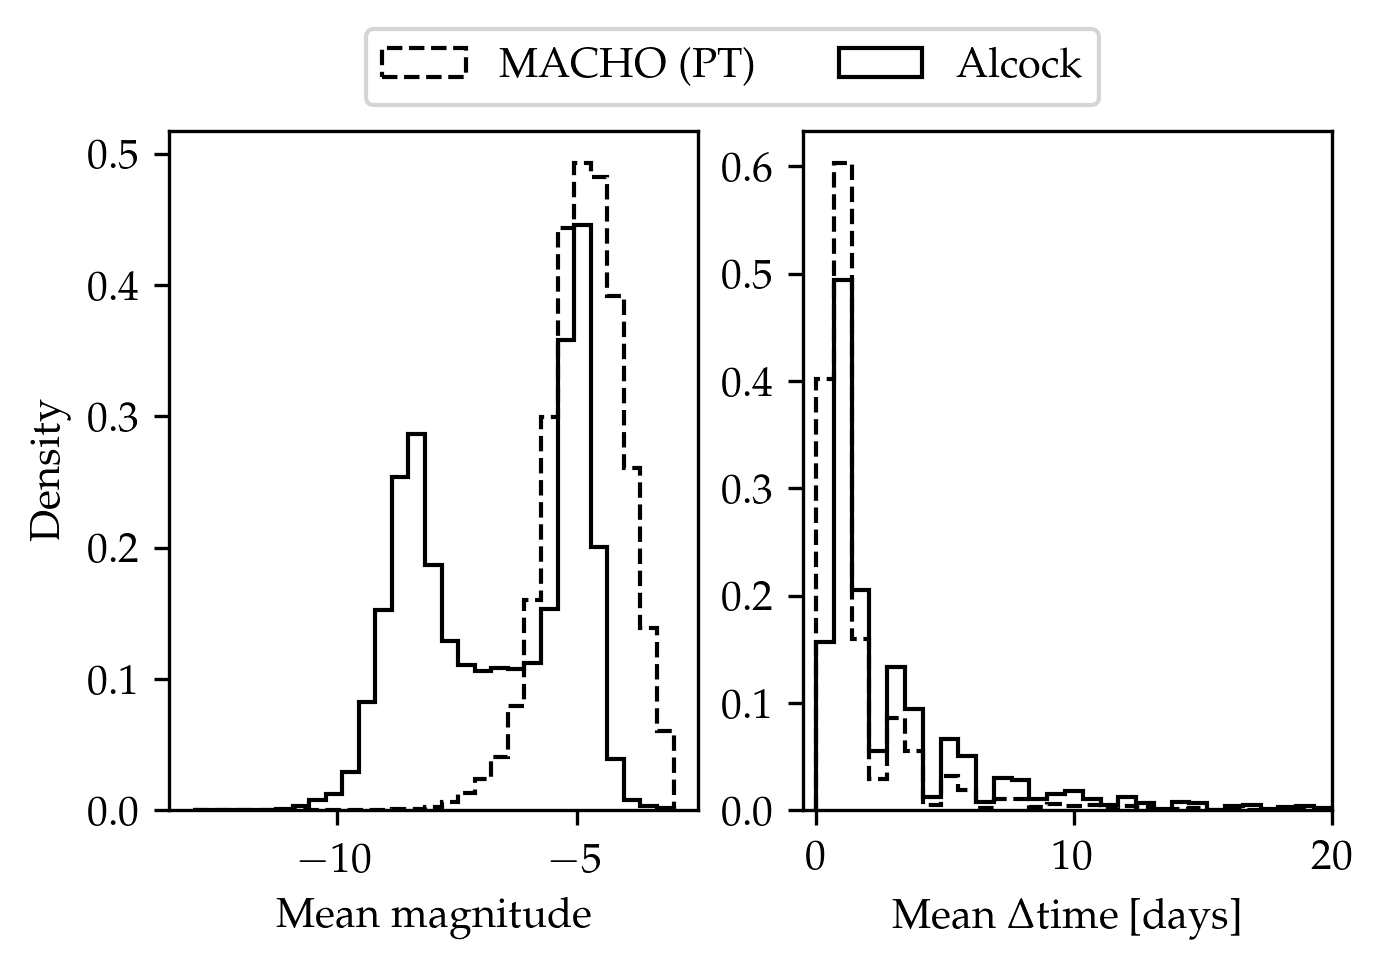

In [149]:
fig, axes = plt.subplots(1,2, figsize=(5,3), dpi=300, sharex=False, 
                         gridspec_kw={'hspace': 0., 'wspace': 0.2})

ls = ['--', '-']
labels = ['MACHO (PT)', 'Alcock']
bins = [800, 920]
for i, (dt, mg) in enumerate(zip(data_0, data_1)):
    print(i)
    axes[0].hist(mg, bins=np.linspace(-13, -3, 30), histtype='step', linestyle=ls[i], color='k', density=True,label=labels[i])
    axes[0].set_xlabel('Mean magnitude')
    axes[0].set_ylabel('Density')
    
    axes[1].hist(dt, bins=np.linspace(0, 20, 30), density=True, histtype='step', linestyle=ls[i], color='k', label=labels[i])
    axes[1].set_xlim(-0.5, 20)
    axes[1].set_xlabel('Mean $\Delta$time [days]')
    axes[1].legend(bbox_to_anchor=(0.6, 1.18), ncol=2)

In [150]:
fig.savefig('presentation/figures/alcock_vs_macho.pdf', format='pdf', bbox_inches='tight')